[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stanford-Sustainable-Systems-Lab/CEE_272R_spring_2025/blob/main/Discussion_Sections/Discussion3/Disc_3_starter.ipynb)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## CVXPY Syntax

### Variables

Decision variables are defined similar to Numpy arrays and must be defined using the cp.Variable function. Constant data can be defined as usual (with Numpy array).

In [2]:
#e.g.
var_vector_1 = cp.Variable((2,))
var_matrix_2 = cp.Variable((4,2))

#define constant matrix
A = np.ones((2,2))
A[1,0]=3
A[1,1]=-2

### Constraints

In Python, the problem constraints are defined as a list. Each list element is a constraint, with either <, <=, >, >=, or == operators between the two expressions. Constraints should be a function of fixed variables/data and cp variables.

In [3]:
#e.g.
constraints = []
constraints.append(A @ var_vector_1 <=0)
constraints.append(var_vector_1>=0)


### Objective

The objective is an expression as a function of fixed variables and previously defined cp variables. Note that certain functions (such as sum and max) are cp functions, not np functions. See https://www.cvxpy.org/tutorial/functions/index.html for an exhaustive list of possible functions!

In [4]:
#eg
obj = cp.max(var_vector_1)

### Solving the problem

To solve the optimization problem, you first create a cp Problem object, then call the function "solve".

In [5]:
opt_val = cp.Problem(cp.Minimize(obj), constraints)
opt_val.solve()


0.0

### DCP Rules

CVXPY ensures that the objective and constraints are convex by checking them against a set of disciplined convex programming (DCP) rules. If your problem is not convex, you're not going to get around the DCP rules. However, sometimes the problem is formulated in a non-DCP way and can be rewritten.

### Reporting Results

To report optimal value and variable results, use "variable.value" syntax. Remember that the optimal value is of the function you're tryint to minimize, which is different from the optimal values of the decision variables.

In [6]:
print(opt_val.value)
print(var_vector_1.value)

0.0
[0. 0.]


## CVXPY Example


$ \textrm{minimize} ~c^T x\\$
$\textrm{s.t.}\hspace{2.5em} Ax\leq b \\$

Given $A \in \mathbb{R}^{m \times n}, x \in \mathbb{R}^{n}, c \in \mathbb{R}^{n} , b \in \mathbb{R}^{m} , m=15,  n=10 $, write a program to solve this problem. Print out the optimal value and value of x.

Taken from: https://www.cvxpy.org/examples/basic/linear_program.html

In [7]:
# Generate a random non-trivial linear program.
m = 15
n = 10

s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)

x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A @ x0 
c = -A.T @ lamb0

# Define and solve the CVXPY problem.




## Optimizing the Control of Chargers in a Workplace Parking Lot

Imagine you are tasked with optimizing the EV chargers at a workplace parking lot. Assume the scenario involves three electric vehicles parked at different times throughout the day. You know each vehicle's state of charge ($SOC_0$) upon arrival, their battery capacity (Batt_c), and the times they arrive ($t_0$) and depart ($t_f$):

- Car A: $SOC$ at arrival: 40% ($SOC_0^A$ = 0.4), Battery capacity ($Batt_c^A$): 75 kWh, Arrival ($t_0^A$): 9 AM, Departure ($t_f^A$): 2 PM
- Car B: $SOC$ at arrival: 35% ($SOC_0^B$ = 0.35), Battery capacity ($Batt_c^B$): 64 kWh, Arrival ($t_0^B$): 10 AM, Departure ($t_f^B$): 3 PM
- Car C: SOC at arrival: 25% ($SOC_0^C$ = 0.25), Battery capacity ($Batt_c^C$): 58 kWh, Arrival ($t_0^C$): 11 AM, Departure ($t_f^C$): 6 PM


The parking lot uses a Time-of-Use (TOU) tariff as follows:
| Energy Rates              | Price |
| :---------------- | ----: |
| Energy Use Peak Price (12:30 am to 6pm) | $ \$0.43/kWh$ |
| Energy Use Off-Peak Price  | $\$0.20/kWh$ |
| Demand rate price (all time) | $\$15/kW$ |

The lot is equipped with Level 2 (L2) chargers that has a maximum charging rate of 20 kW. Assuming that we aim to charge all vehicles to their maximum SOC and the data is discretized at 30-minute intervals ($\Delta t = 0.5$). Please, answer the following questions.


### Setting the problem in the baseline case

In [8]:
delta_t = 1/2 #time step (30 minutes)
timesteps = 48 #24 hours
## Initial SOC for each vehicle
soc_0a = 0.4 #initial state of charge of battery a
soc_0b = 0.35 #initial state of charge of battery b
soc_0c = 0.25 #initial state of charge of battery c
## Desired final SOC (100%)
desired_soc_f = 1 #desired final state of charge of battery 
## EV batt capacity
batt_cap_a = 75 #battery capacity of battery a
batt_cap_b = 64 #battery capacity of battery b
batt_cap_c = 58 #battery capacity of battery c
## Initial and final time for each vehicle
t_0a = 9
t_fa = 14
t_0b = 10
t_fb = 15
t_0c = 11
t_fc = 18

We can obtain the energy demand for each car by solving 
$E_{demand} = (SOC_f^C-SOC_0^C) \times Batt_c$

In [9]:
energy_demand_a = (desired_soc_f - soc_0a)*batt_cap_a
energy_demand_b = (desired_soc_f - soc_0b)*batt_cap_b
energy_demand_c = (desired_soc_f - soc_0c)*batt_cap_c

If we use the maximum power capacity of the L2 chargers, we can charge all the vehicles during their initial hours parked at the workplace. However, this might not be the most cost-effective strategy if we aim to minimize energy costs and reduce impact on the electrical grid. These considerations could provide valuable insights for your final projects. The baseline scenario will be outlined as follows

In [10]:
# Duration of charging assuming max charger power:
l2_max_power = 20
l2_max_in_30_min = l2_max_power*delta_t # 10kWh
duration_charging_a = np.ceil(energy_demand_a/l2_max_in_30_min)  
duration_charging_b = np.ceil(energy_demand_b/l2_max_in_30_min)  
duration_charging_c = np.ceil(energy_demand_c/l2_max_in_30_min)  

In [11]:
#index of the time step corresponding to the initial time
ind_a = int(t_0a/delta_t) 
ind_b = int(t_0b/delta_t)
ind_c = int(t_0c/delta_t)
#create baseline profiles
power_profile_a = np.zeros(timesteps)
power_profile_a[ind_a:ind_a+int(duration_charging_a)] = l2_max_power
power_profile_b = np.zeros(timesteps)
power_profile_b[ind_b:ind_b+int(duration_charging_b)] = l2_max_power
power_profile_c = np.zeros(timesteps)
power_profile_c[ind_c:ind_c+int(duration_charging_c)] = l2_max_power

In [12]:
# Duration of car plugged in:
duration_plugged_in_a = (t_fa -  t_0a)/delta_t
duration_plugged_in_b = (t_fb -  t_0b)/delta_t
duration_plugged_in_c = (t_fc -  t_0c)/delta_t

In [13]:
# create vector with time plugged in
time_plugged_a = np.full(timesteps, np.nan) 
time_plugged_a[ind_a:ind_a+int(duration_plugged_in_a)] = 0 
time_plugged_b = np.full(timesteps, np.nan) 
time_plugged_b[ind_b:ind_b+int(duration_plugged_in_b)] = 0
time_plugged_c = np.full(timesteps, np.nan) 
time_plugged_c[ind_c:ind_c+int(duration_plugged_in_c)] = 0

### Plotting baseline case

In [14]:
def plot_vehicle_profiles(power_profiles, time_plugged, day_timesteps, colors, control_case):
    fig, axs = plt.subplots(len(power_profiles)+1, 1, figsize=(10, 8))  # 2x2 grid of axes
    fig.suptitle('Power profiles - {}'.format(control_case))
    for pp, tp, i in zip(power_profiles, time_plugged, range(len(power_profiles))):
        axs[i].plot(day_timesteps, pp, color = colors[i], label='Power profile')
        axs[i].scatter(day_timesteps, tp, color = "black", label='Time plugged in')
        axs[i].legend()
        axs[i].grid()
        axs[i].set_ylabel('Power (kW)')
        axs[i].set_xlabel('Time (h)')
    axs[-1].plot(day_timesteps, np.sum(power_profiles, axis=0), color = "black", label='Parking Lot - Total Power profile')
    axs[-1].legend()
    axs[-1].grid()
    plt.tight_layout()

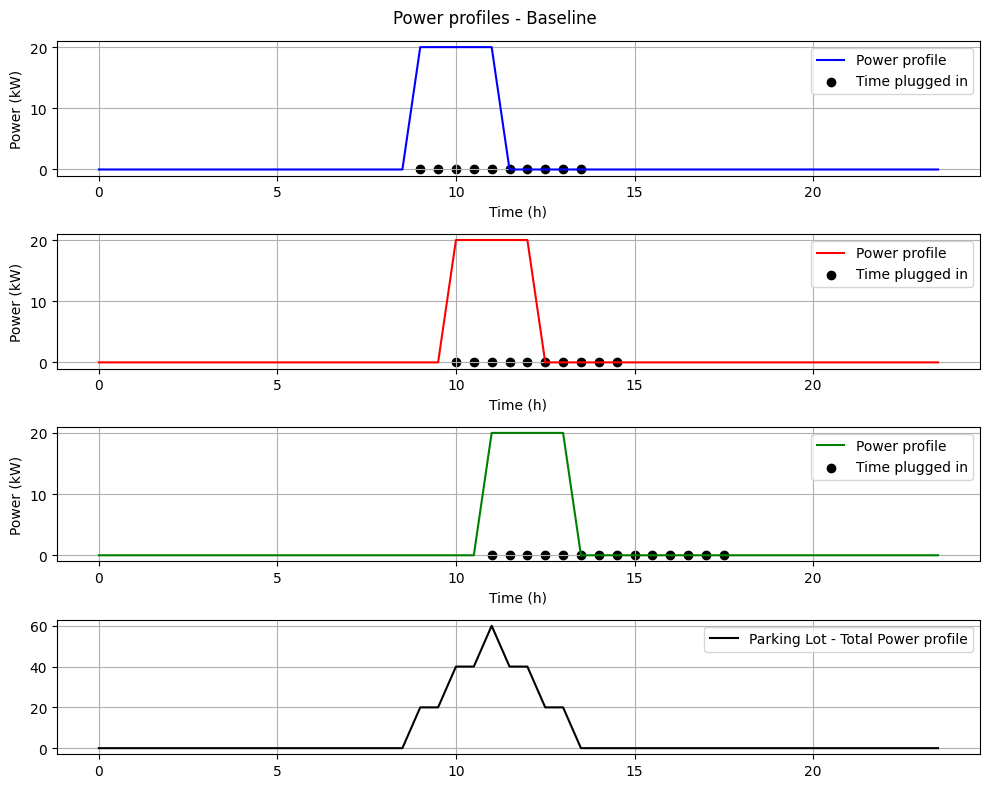

In [15]:
power_profiles = [power_profile_a, power_profile_b, power_profile_c]
time_plugged = [time_plugged_a, time_plugged_b, time_plugged_c]
colors = ["blue", "red", "green"]
day_timesteps = np.arange(0, timesteps/2, 0.5)
plot_vehicle_profiles(power_profiles, time_plugged, day_timesteps, colors, control_case="Baseline")

## (a) How can we optimize vehicle charging to minimize energy use costs?

### Calculate Optimal Energy Use Costs and Plot New Power Profiles and Total Power

In [16]:
## Create price vector for the day
# TODO

In [17]:
## Plot price vector for the day
# TODO

In [18]:
# Create Variables
# TODO
# Create objective function
# TODO

# Create constraints
constraints = [
    # Vehicle A 
    # TODO
    # Vehicle B 
    # TODO
    # Vehicle C
    # TODO
    # Total power
    # TODO
]
#problem = cp.Problem(obj, constraints)

In [19]:
# Solve problem
# TODO

In [20]:
# Plot results
# power_profiles = [power_a.value, power_b.value, power_c.value]
# time_plugged = [time_plugged_a, time_plugged_b, time_plugged_c]
# colors = ["blue", "red", "green"]
# day_timesteps = np.arange(0, timesteps/2, 0.5)
# plot_vehicle_profiles(power_profiles, time_plugged, day_timesteps, colors, control_case="Optimal Energy Use")

## (b) How can we optimize vehicle charging to minimize demand rate costs?

### Calculate Optimal Demand Rate Costs and Plot New Power Profiles and Total Power

In [21]:
# Create Variables
# TODO
# Create objective function
# TODO

# Create constraints
constraints = [
    # Vehicle A 
    # TODO
    # Vehicle B 
    # TODO
    # Vehicle C
    # TODO
    # Total power
    # TODO
]

In [22]:
## New objective function
#TODO

In [23]:
# Solve problem
#TODO

In [24]:
# Plot results
# power_profiles = [power_a.value, power_b.value, power_c.value]
# time_plugged = [time_plugged_a, time_plugged_b, time_plugged_c]
# colors = ["blue", "red", "green"]
# day_timesteps = np.arange(0, timesteps/2, 0.5)
# plot_vehicle_profiles(power_profiles, time_plugged, day_timesteps, colors, control_case="Optimal Demand Rate")

## (c) How can we optimize vehicle charging to minimize the electricity bill?

### Calculate Optimal Electricity Bill and Plot New Power Profiles and Total Power

In [25]:
# Create Variables
# TODO
# Create objective function
# TODO

# Create constraints
constraints = [
    # Vehicle A 
    # TODO
    # Vehicle B 
    # TODO
    # Vehicle C
    # TODO
    # Total power
    # TODO
]

In [26]:
## New objective function
#TODO 

In [27]:
# Solve problem
#TODO

In [28]:
# Plot results
# power_profiles = [power_a.value, power_b.value, power_c.value]
# time_plugged = [time_plugged_a, time_plugged_b, time_plugged_c]
# colors = ["blue", "red", "green"]
# day_timesteps = np.arange(0, timesteps/2, 0.5)
# plot_vehicle_profiles(power_profiles, time_plugged, day_timesteps, colors, control_case="Optimal Electricity Bill")

## (d) Compare the Electricity Bills for Baseline and Optimal Charger Control

### What was the percentage decrease in the Electricity Bill?

In [29]:
# Solve for baseline
#TODO

In [30]:
# print("Baseline electrcity bill: $", baseline_elec_bill)
# print("Optimal electricity bill: $", format(opt_cost, ".2f"))
# print("Savings: %",format((baseline_elec_bill - opt_cost)/baseline_elec_bill*100,".2f"))